In [6]:
import json
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn import metrics
from math import cos, asin, sqrt, pi
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import re
import sys
import seaborn
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.preprocessing import MultiLabelBinarizer
from wordcloud import WordCloud
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)

sns.set_style('darkgrid')
from shapely.geometry import Point, Polygon

%matplotlib inline

In [2]:
# To get WordCloud for features selection
# Help to visualization of which features are interested by the renter

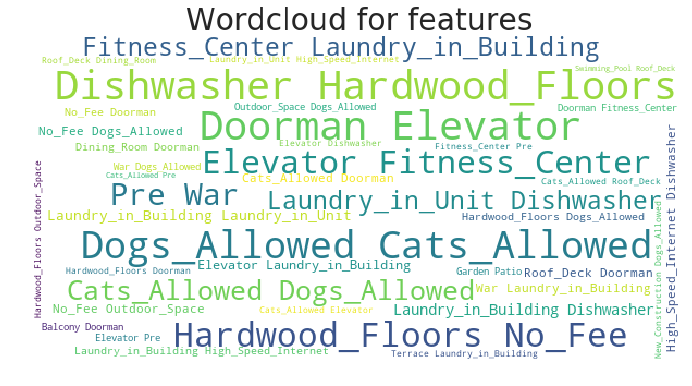

In [3]:
# load data from zip file
d = None  
train_df = None  
with zipfile.ZipFile("train.json.zip", "r") as z:
   for filename in z.namelist():    
      with z.open(filename) as f:  
         train_df = f.read()  
         d = json.loads(train_df.decode("utf-8"))
        
train_df = pd.DataFrame.from_dict(d)

# ref: https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-2-connect
text = ''
text_da = ''
text_desc = ''
for ind, row in train_df.iterrows():
    for feature in row['features']:
        text = " ".join([text, "_".join(feature.strip().split(" "))])
    text_da = " ".join([text_da,"_".join(row['display_address'].strip().split(" "))])
    #text_desc = " ".join([text_desc, row['description']])
text = text.strip()
text_da = text_da.strip()
text_desc = text_desc.strip()

plt.figure(figsize=(12,6))
wordcloud = WordCloud(background_color='white', width=600, height=300, max_font_size=50, max_words=40).generate(text)
wordcloud.recolor(random_state=0)
plt.imshow(wordcloud)
plt.title("Wordcloud for features", fontsize=30)
plt.axis("off")
plt.show()

In [19]:
train_data = pd.read_csv('train_values.csv').copy()
train_data = train_data.drop(columns=['Unnamed: 0'])
train_data = train_data.sample(frac=0.1, replace=True) # random seed 

# Get X and y(label)
y = train_data['interest_level'].copy()
del train_data['interest_level']
del train_data['distance']
X = train_data.copy()

# Initial model using Support Vector Machine
# Cannot use all the features for training model. Because SVM is computational complexity
# If we don't apply feature selection first, we won't get results in few minutes. 

clf = Pipeline([
  ('Support Vector Machine', SVC(kernel='linear', C=1 , probability=True))
])

# scores = cross_val_score(clf, X, y, cv=5)

X_train, X_valid, y_train, y_valid = train_test_split(X, y)

clf.fit(X_train, y_train)

print(" trainning vs. validation score: ", clf.score(X_train, y_train), clf.score(X_valid, y_valid))
print("classification report:\n ", classification_report(y_valid , clf.predict(X_valid)))

# no sample 0.6946291041751115
# sample 0.2 0.6976084948219402
# scores.mean()

 trainning vs. validation score:  0.7102702702702702 0.6952998379254457
classification report:
                precision    recall  f1-score   support

           0       0.72      0.96      0.82       857
           1       0.41      0.11      0.17       279
           2       0.45      0.05      0.09        98

    accuracy                           0.70      1234
   macro avg       0.53      0.37      0.36      1234
weighted avg       0.63      0.70      0.62      1234



In [18]:
test_data = pd.read_csv('test_submit.csv')
test_data = test_data.drop(columns=['Unnamed: 0'])

test_data_forPredict = test_data.copy()
test_data_forPredict = test_data_forPredict.drop(columns=['listing_id'])

result = clf.predict_proba(test_data_forPredict)
submit = {'listing_id':test_data['listing_id'], 'high': result[:,1], 'medium':result[:,2], 'low':result[:,0]}
pd.DataFrame(submit).to_csv('submission.csv',index = False)

In [191]:
# SVM is computational complexity. Therefore, we cannot use the whole data to build the model 
# We need to sample small subset of data to test and optimize our model. 
# Therefore, we must to select the sample data as representive as possible, in general, with higher validation score

def select_best_subdata(number_iter):
    
    scores = 0
    best_scores = 0
    
    for i in range(number_iter):
        train_data = pd.read_csv('train_values.csv')
        train_data = train_data.drop(columns=['Unnamed: 0'])
#         train_data = train_data.sample(frac=0.1, replace=True) # random seed 

        # Get X and y(label)
        y = train_data['interest_level']
        del train_data['interest_level']
        X = train_data

        clf = Pipeline([
          ('normalization', MinMaxScaler(feature_range = (0,1))),
          ('Support Vector Machine', SVC(probability=True, kernel='rbf', C=1))
        ])

        scores = cross_val_score(clf, X, y, cv=2).mean()
        if scores > best_scores:
            best_scores = scores
            sample_data = train_data
            model = clf
    
    return (best_scores , sample_data , y , model)

# (best_scores , sample_data , y , model) use as global 
(best_scores , sample_data , y , model) = select_best_subdata(1)

print(best_scores)

KeyboardInterrupt: 

In [29]:
# There are many feature in descritption. Use SelectKBest to determine which features are valuable to use 
# Only choose "hardwood floor" , "laundry in unit" in the description 

X = sample_data.copy()
del X['latitude']
del X['longitude']

scores = 0
best_score = 0

for k in range(2, 31):
    selector = SelectKBest(chi2, k=k)
    selector.fit(X, y)
    cols = selector.get_support(indices=True)
    print('Best', k, 'features:')
    for i in cols:
        print(' ', X.columns[i], end=', ')

    clf = Pipeline([
      ('normalization', MinMaxScaler(feature_range = (0,1))),
      ('feature_selection', selector),
      ('Support Vector Machine', SVC(probability=True, kernel='rbf', C=1))
    ])

    scores = cross_val_score(clf, X, y, cv=5).mean()
    if scores > best_score:
        best_score = scores
        model = clf

    print("\nscores:" , scores)

In [220]:
# From the lat-lon data: 2 sets of label-encoded clusters from DBSCAN with 15 and 50 clusters. Distance from the listing to the top-5 cluster 
#    centers in terms of number of observations. So, actually it's a distance to the most dense areas.
# https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/discussion/32118

from sklearn.cluster import DBSCAN

train_data = pd.read_csv('train_values.csv').copy()
train_data = train_data.drop(columns=['Unnamed: 0'])

# Get X and y(label)
y = train_data['interest_level']
del train_data['interest_level']
X = train_data


# X = sample_data.copy()

def distance_for_twopoints(lat1, lon1, lat2, lon2):
    p = pi/180 
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    return 12742 * asin(sqrt(a)) 

vec_distance_for_two = np.vectorize(distance_for_twopoints)

def distance(location):
    distance = vec_distance_for_two(location[0],location[1],location_lat_lon['latitude'],
                                                            location_lat_lon['longitude']);
    min_dis = min(distance)
    return min_dis


lat_lon_clustering = DBSCAN(eps=0.002 , min_samples=10).fit(X[['latitude' , 'longitude']])
lat_lon_clustering = pd.DataFrame(lat_lon_clustering.labels_ , columns = ["cluster"])

sorted_lat_lon_clustering = lat_lon_clustering.sort_values(by='cluster', ascending=True)
location_list = [3642 , 3733 , 2728 , 4198 , 2704]
# sorted_lat_lon_clustering.groupby(by="cluster").count()

location_lat_lon = []
for i in range(5):
    index = location_list[i]
    location_lat_lon.append(X.iloc[index][['latitude' , 'longitude']])
location_lat_lon = pd.DataFrame(location_lat_lon)

X['location'] = X[['latitude','longitude']].values.tolist()
X['cluster_distance'] = X['location'].apply(distance)

X['location'] = X[['latitude','longitude']].values.tolist()
X['cluster_distance'] = X['location'].apply(distance)

X = X.drop(["location"] , axis=1)
X.head()

bathrooms  bedrooms  latitude  longitude  price  num_photos  distance  dining room  pre war  laundry in build  dishwash  hardwood floor  dogs allow  cats allow  doorman  elev  no fe  laundry in unit  fitness cent  roof deck  outdoor spac  stainless steel  steel applianc  new york  high ceil  closet space  live room  real estat  call text  washer dryer  apart featur  cluster_distance
0        1.0         1   40.7108   -73.9539   2400          12  0.304673            1        1                 1         1               1           1           1        0     0      0                0             0          0             0                0               0         0          0             1          0           0          0             0             1          4.152917
1        1.0         2   40.7513   -73.9722   3800           6  0.323877            0        0                 1         1               1           0           0        1     1      1                0             0          0             0                0               0         0          0             0          0           0          1             0             0          0.553258
2        1.0         2   40.7575   -73.9625   3495           6  0.552144            0        0                 1         1               1           0           0        1     1      0                1             0          0             0                1               1         0          0             1          0           0          1             0             0          0.528681
3        1.5         3   40.7145   -73.9425   3000           5  0.131090            0        0                 0         0               0           0           0        0     0      0                0             0          0             0                0               1         0          0             0          0           0          0             1             1          3.915430
4        1.0         0   40.7439   -73.9743   2795           4  0.698529            0        0                 1         0               0           0           0        1     1      0                0             1          0             0                0               0         0          0             0          0           0          0             0             0          1.287308

In [221]:
# Choose features, in previous function, we determine "hardwood floor" , "laundry in unit" to use 
# bathrooms , bedrooms , price , distance --> Basic features we choose 
# Add more features 
#     price_over_room
#     cluster_distance

X['price_over_room'] = X['price'] / (1 + 0.5 * X['bathrooms'] + X['bedrooms'])

# X = X[['bathrooms' , 'bedrooms' , 'price' , "num_photos"
#                 'hardwood floor' , 'laundry in unit',
#                  'price_over_room' , 'cluster_distance']].copy()
X = X.drop(columns = ["distance" , "cluster_distance"])

clf = Pipeline([
#   ('normalization', MinMaxScaler(feature_range = (0,1))),
  ('Support Vector Machine', SVC(probability=True, kernel='rbf', C=1))
])

# scores = cross_val_score(clf, X, y, cv=2)
clf.fit(X , y)
# print("scores:" , scores.mean())

# train_x, test_x, train_y, test_y = train_test_split(X, y)

# train_scores = cross_val_score(clf, train_x, train_y, cv=2)
# test_scores = cross_val_score(clf, test_x, test_y, cv=2)

# print("train_scores:" , train_scores.mean())
# print("test_scores:" , test_scores.mean())

Pipeline(memory=None,
         steps=[('Support Vector Machine',
                 SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

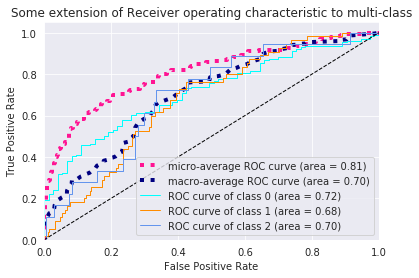

In [4]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle
from sklearn import svm
# apply ROC metrics of decision tree
# cite: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

train_data = pd.read_csv('train.csv').copy()
train_data = train_data.drop(columns=['Unnamed: 0'])
train_data = train_data.sample(frac=0.01, replace=True) # random seed 


# Get X and y(label)
y = train_data['interest_level'].copy()
del train_data['interest_level']
X = train_data.copy()


y = label_binarize(y, classes=[0, 1, 2])

n_classes = y.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)
# model = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=10)
# # model = DecisionTreeClassifier(max_depth=10, min_samples_leaf = 10)
# # dt_model.fit(X_train, y_train)

classifier = OneVsRestClassifier(svm.SVC(kernel='linear', 
                                 random_state=0))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# # Plot of a ROC curve for a specific class
# plt.figure()
lw = 1
# plt.plot(fpr[2], tpr[2], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [222]:
test_data = pd.read_csv('test_submit.csv')
test_data = test_data.drop(columns=['Unnamed: 0'])
test_data['price_over_room'] = test_data['price'] / (1 + 0.8 * test_data['bathrooms'] + test_data['bedrooms'])

# lat_lon_clustering = DBSCAN(eps=0.002 , min_samples=10).fit(test_data[['latitude' , 'longitude']])
# lat_lon_clustering = pd.DataFrame(lat_lon_clustering.labels_ , columns = ["cluster"])

# sorted_lat_lon_clustering = lat_lon_clustering.sort_values(by='cluster', ascending=True)
# location_list = [3642 , 3733 , 2728 , 4198 , 2704]
# # sorted_lat_lon_clustering.groupby(by="cluster").count()

# location_lat_lon = []
# for i in range(5):
#     index = location_list[i]
#     location_lat_lon.append(test_data.iloc[index][['latitude' , 'longitude']])
# location_lat_lon = pd.DataFrame(location_lat_lon)

# test_data['location'] = test_data[['latitude','longitude']].values.tolist()
# test_data['cluster_distance'] = test_data['location'].apply(distance)

# test_data['location'] = test_data[['latitude','longitude']].values.tolist()
# test_data['cluster_distance'] = test_data['location'].apply(distance)

# test_data = test_data.drop(["location"] , axis=1)

test_data_forPredict = test_data.copy()
test_data_forPredict = test_data_forPredict.drop(columns=['listing_id'])

test_data.head()

result = clf.predict_proba(test_data_forPredict)
submit = {'listing_id':test_data['listing_id'], 'high': result[:,0], 'medium':result[:,2], 'low':result[:,1]}
pd.DataFrame(submit).to_csv('submission.csv',index = False)

submit

{'listing_id': 0        7142618
 1        7210040
 2        7174566
 3        7191391
 4        7171695
           ...   
 74654    6928108
 74655    6906674
 74656    6897967
 74657    6842183
 74658    6889319
 Name: listing_id, Length: 74659, dtype: int64,
 'high': array([0.7381408 , 0.7826297 , 0.78932519, ..., 0.77881256, 0.4616757 ,
        0.61885607]),
 'medium': array([0.03104233, 0.0280637 , 0.02692536, ..., 0.02789423, 0.10956817,
        0.05664678]),
 'low': array([0.23081687, 0.1893066 , 0.18374944, ..., 0.19329322, 0.42875613,
        0.32449714])}